In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from skimage.feature import local_binary_pattern, hog

# Parameters
radius = 3
n_points = 8 * radius

# Path to your main texture dataset folder
dataset_path = r'C:\Users\gomes\Documents\textures 3'


In [2]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern

# Constants for LBP
radius = 1
n_points = 8 * radius

# Function to extract features using LBP, HOG, and SIFT
def extract_features(image):
    # Local Binary Pattern (LBP)
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    
    # Histogram of Oriented Gradients (HOG)
    hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
    
    # Scale-Invariant Feature Transform (SIFT)
    sift = cv2.SIFT_create()
    keypoints, sift_features = sift.detectAndCompute(image, None)
    
    if sift_features is not None:
        sift_features = sift_features.flatten()
        # Limit the number of SIFT features to a fixed size (e.g., 128)
        if sift_features.size > 128:
            sift_features = sift_features[:128]
        else:
            # Pad with zeros if there are fewer than 128 features
            sift_features = np.pad(sift_features, (0, 128 - sift_features.size), 'constant')
    else:
        # In case no keypoints are detected, return a zero array
        sift_features = np.zeros(128)
    
    # Combine LBP, HOG, and SIFT features
    combined_features = np.hstack((lbp_hist, hog_features, sift_features))
    
    return combined_features

# Data augmentation functions
def augment_image(image):
    augmented_images = []
    height, width = image.shape

    # Rotation
    for angle in [15, 30, 45]:
        M = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
        rotated_image = cv2.warpAffine(image, M, (width, height), borderMode=cv2.BORDER_REFLECT)
        augmented_images.append(rotated_image)

    # Translation
    translations = [(10, 0), (0, 10), (-10, 0), (0, -10)]
    for tx, ty in translations:
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        translated_image = cv2.warpAffine(image, M, (width, height), borderMode=cv2.BORDER_REFLECT)
        augmented_images.append(translated_image)

    # Scaling
    for scale in [0.9, 1.1]:
        scaled_image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        if scaled_image.shape[0] >= height and scaled_image.shape[1] >= width:
            scaled_image = cv2.resize(scaled_image, (width, height), interpolation=cv2.INTER_LINEAR)
        augmented_images.append(scaled_image)

    # Flipping
    flipped_image = cv2.flip(image, 1)  # Horizontal flip
    augmented_images.append(flipped_image)

    return augmented_images

# Function to combine feature extraction and augmentation
def augment_and_extract_features(image_path, label):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image = cv2.resize(image, (200, 200))
        features = extract_features(image)
        
        augmented_images = augment_image(image)
        
        features_list = [features]
        for aug_image in augmented_images:
            aug_image = cv2.resize(aug_image, (200, 200))  # Ensure size consistency
            aug_features = extract_features(aug_image)
            features_list.append(aug_features)
        
        return np.array(features_list), [label] * len(features_list)
    return None, None


In [3]:
# Prepare the dataset
data = []
labels = []

for texture_type in os.listdir(dataset_path):
    texture_folder = os.path.join(dataset_path, texture_type)
    
    if os.path.isdir(texture_folder):
        for image_name in os.listdir(texture_folder):
            image_path = os.path.join(texture_folder, image_name)
            features, label_list = augment_and_extract_features(image_path, texture_type)
            if features is not None:
                data.extend(features)
                labels.extend(label_list)

data = np.array(data)
labels = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Apply feature selection
def select_features(X_train, y_train, X_test, k=50):
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected, selector

X_train_selected, X_test_selected, selector = select_features(X_train, y_train, X_test, k=50)


In [4]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Define models and hyperparameter grids
models = {
    'Random Forest': RandomForestClassifier(random_state=42)
}

param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [ 100, 200],
        'classifier__max_depth': [None, 20, 30]

}}


In [5]:
# Function to tune models
def tune_models(models, param_grids, X_train, y_train):
    best_models = {}
    
    for name, model in models.items():
        pipeline = Pipeline([
            ('pca', PCA(n_components=30)),
            ('classifier', model)
        ])
        
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        
        best_models[name] = grid_search.best_estimator_
    
    return best_models

# Tune models
tuned_models = tune_models(models, param_grids, X_train_scaled, y_train)

# Function to evaluate models
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    trained_models = {}
    
    for name, model in models.items():
        pipeline = Pipeline([
            ('pca', PCA(n_components=30)),
            ('classifier', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = {
            'accuracy': accuracy,
            'report': report
        }
        trained_models[name] = pipeline
    
    return results, trained_models

# Evaluate tuned models
results, trained_models = evaluate_models(tuned_models, X_train_scaled, X_test_scaled, y_train, y_test)

# Print results
for model_name, metrics in results.items():
    print(f"Tuned Model: {model_name}")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print("Classification Report:")
    print(metrics['report'])
    print("-" * 60)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tuned Model: Random Forest
Accuracy: 0.82
Classification Report:
{'corduroy': {'precision': 0.8021739130434783, 'recall': 0.8431073876618431, 'f1-score': 0.8221314519123654, 'support': 1313.0}, 'cotton': {'precision': 0.8464052287581699, 'recall': 0.7807083647324793, 'f1-score': 0.8122304978439827, 'support': 1327.0}, 'denim': {'precision': 0.919931856899489, 'recall': 0.9262435677530018, 'f1-score': 0.9230769230769231, 'support': 1166.0}, 'linin': {'precision': 0.7858942065491183, 'recall': 0.7653311529026983, 'f1-score': 0.7754763877381938, 'support': 1223.0}, 'wool': {'precision': 0.7481751824817519, 'recall': 0.7824427480916031, 'f1-score': 0.7649253731343284, 'support': 1310.0}, 'accuracy': 0.8177946048272599, 'macro avg': {'precision': 0.8205160775464015, 'recall': 0.8195666442283251, 'f1-score': 0.8195681267411586, 'support': 6339.0}, 'weighted avg': {'precision': 0.8187936165315741, 'recall': 0.8177946048272599, 'f1-sc

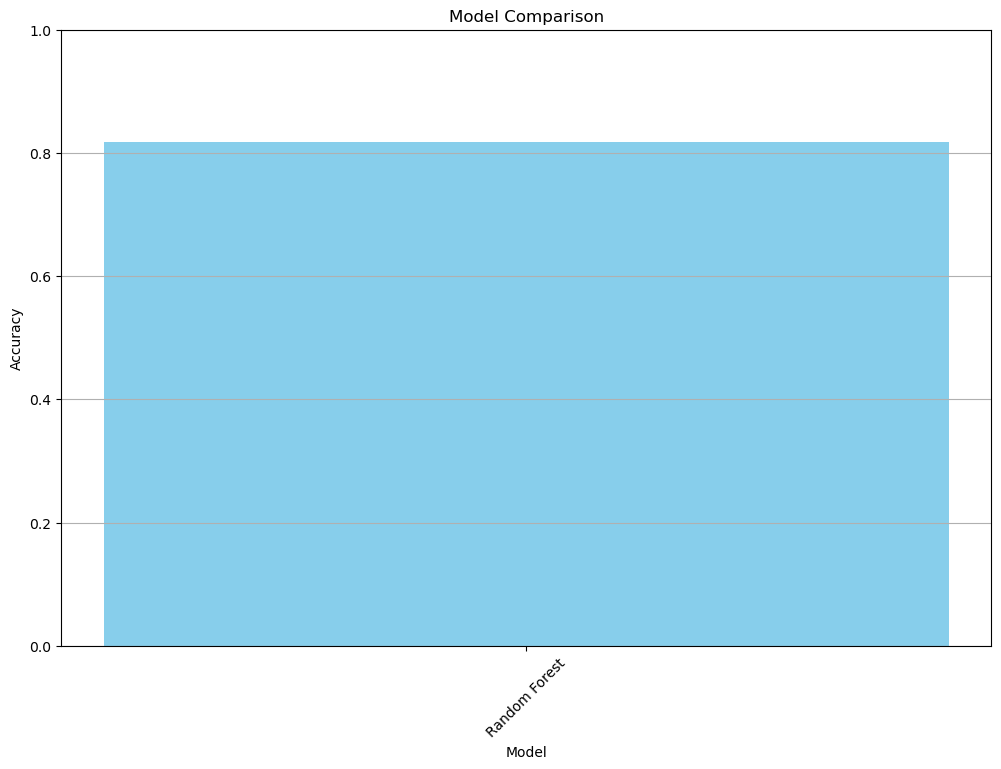

In [6]:
# Plot results
def plot_results(results):
    names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in names]
    
    plt.figure(figsize=(12, 8))
    plt.bar(names, accuracies, color='skyblue')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Comparison')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.show()

plot_results(results)


In [24]:
# Function to make predictions with a given model
def predict_image(image_path, model_name):
    # Load and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found or invalid image path.")
    
    image = cv2.resize(image, (200, 200))
    
    # Extract features
    features = extract_features(image)
    
    # Apply the same feature selection
    features_selected = selector.transform([features])
    
    # Normalize the features and predict using the model pipeline
    features_scaled = scaler.transform(features_selected)
    prediction = trained_models[model_name].predict(features_scaled)
    
    return prediction[0]

# Example usage
image_path =r"C:\Users\gomes\Downloads\WhatsApp Image 2024-08-28 at 22.28.20_d1c3cdbf.jpg"

predicted_label = predict_image(image_path, 'Random Forest')
print(f"Predicted label for the image: {predicted_label}")




Predicted label for the image: cotton
